# User Retention Analysis for a Supermarket Chain

Welcome,  we will be focusing specifically on the Spanish market of the retail business and analyzing the retention rate over the course of one year. This information can provide valuable insights into how the Spanish market behaves and whether there are any unique factors that may influence user retention in this market.

To conduct this analysis, we will be utilizing a dataset that includes information about customer behavior in the Spanish market over the course of one year. This dataset includes data such as customer ID, purchase dates, purchase amounts, and other relevant information. We will be using this data to construct cohorts based on the customers' initial purchase date and then analyzing how these cohorts behave over the course of the year.

By focusing on the Spanish market and analyzing retention over a year, we hope to gain a deeper understanding of the factors that contribute to user retention in this market. This information can then be used to make data-driven decisions about customer retention strategies that are tailored specifically to the Spanish market, ultimately leading to increased customer loyalty and revenue for the business. So, let's dive into the analysis and see what insights we can uncover!

*The information presented below has been modified solely for educational purposes and does not reflect the accuracy or completeness of the original data. Any similarities to actual data are purely coincidental. This information should not be used for any practical purposes, and we cannot guarantee its reliability or usefulness. The original sources of the data have not been disclosed, and we take no responsibility for any consequences that may arise from the use of this modified information.*

In [23]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [25]:
raw  = pd.read_csv('Mercadona.csv')
df = raw.copy()
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2021 08:26,2.55,17850.0,Spain
1,536365,71053,WHITE METAL LANTERN,6,01/12/2021 08:26,3.39,17850.0,Spain
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2021 08:26,2.75,17850.0,Spain
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2021 08:26,3.39,17850.0,Spain
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2021 08:26,3.39,17850.0,Spain


In [5]:
df_spain = df[df['Country']=='Spain'].copy()

### Exploratory Data Analysis of df_spain 

In [26]:
# Get basic information about the DataFrame
df_spain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19990 entries, 0 to 541890
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   CustomerID   19990 non-null  float64       
 1   InvoiceNo    19990 non-null  object        
 2   InvoiceDate  19990 non-null  datetime64[ns]
 3   order_month  19990 non-null  period[M]     
 4   cohort       19990 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), object(1), period[M](2)
memory usage: 937.0+ KB


In [27]:
# Get summary statistics of numerical columns
df_spain.describe()

,CustomerID
count,19990.000000
mean,15472.932866
std,1632.278090
min,12346.000000
25%,14081.000000
50%,15440.000000
75%,16898.000000
max,18287.000000


In [28]:
# Check for missing values
df_spain.isnull().sum()

CustomerID     0
InvoiceNo      0
InvoiceDate    0
order_month    0
cohort         0
dtype: int64

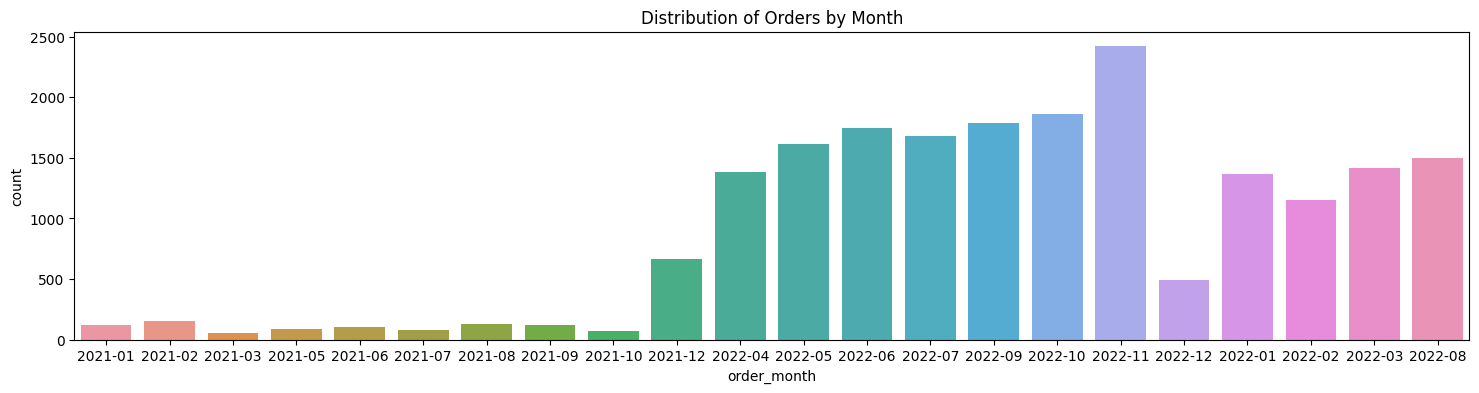

In [36]:
# Visualize the distribution of the order_month column
plt.figure(figsize=(18,4))
sns.countplot(data=df_spain, x='order_month')
plt.title('Distribution of Orders by Month')
plt.show()

### Data Scrubbing

In [40]:
#Drop CustumerID and duplicates
df_spain.dropna(subset=['CustomerID'], inplace=True)
df_spain = df_spain[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

In [41]:
#Clculate an aggregate metric indicating how many orders were placed by each customer.
n_orders = df_spain.groupby(['CustomerID'])['InvoiceNo'].nunique()

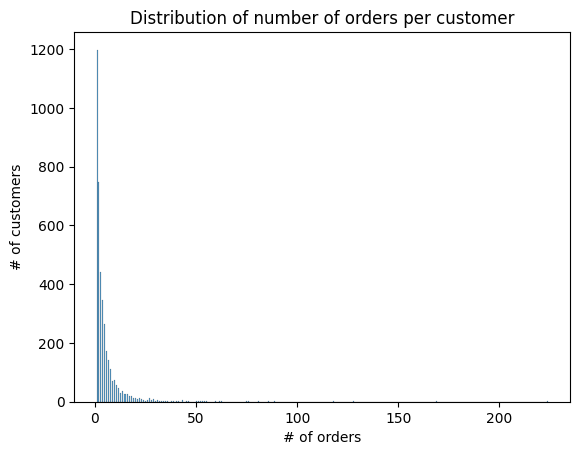

In [42]:
ax = sns.histplot(n_orders, kde=False, stat='count')
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');


In [43]:
#Change Invoice Date to DateTime and Sort the by date
df_spain['InvoiceDate'] = df_spain['InvoiceDate'].apply(pd.to_datetime)
df_spain['InvoiceDate'].sort_values(ascending=False) 

394678   2022-12-10 17:19:00
393986   2022-12-10 15:49:00
393982   2022-12-10 15:42:00
393970   2022-12-10 15:41:00
393956   2022-12-10 15:39:00
                 ...        
25       2021-01-12 08:35:00
9        2021-01-12 08:34:00
21       2021-01-12 08:34:00
7        2021-01-12 08:28:00
0        2021-01-12 08:26:00
Name: InvoiceDate, Length: 19990, dtype: datetime64[ns]

In [44]:
#Get values after January 1st 2021
df_spain = df_spain[df_spain['InvoiceDate']>='01/01/21']

### Cohort creation

As the next step, we create the cohort and order_month variables. 


The first one indicates the monthly cohort based on the first purchase date (calculated per customer). 
The latter one is the truncated month of the purchase date.

In [45]:
#Cohort creation
df_spain['order_month'] = df_spain['InvoiceDate'].dt.to_period('M')  #Returns numpy array of python datetime.date objects.
df_spain['cohort'] = df_spain.groupby('CustomerID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M')  

In [48]:
#DAggragate Data by cohort and count the number of unique customers in each group

df_cohort = df_spain.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [50]:
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2021-01,2021-01,91,0
1,2021-01,2021-02,8,1
2,2021-01,2021-03,3,2
3,2021-01,2021-05,6,4
4,2021-01,2021-06,6,5


The we need to pivot the df_cohort table in a way that each row contains information about a given cohort and each column contains values for a certain period.

In [52]:
#Table pivot
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

To obtain the retention matrix, we need to divide the values each row by the row's first value,
which is actually the cohort size — all customers who made their first purchase in the given month.

In [53]:
#Create Matrix
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cohort,,,,,,,,,,,,,,,,,,,,,
2021-01,1.0,0.087912,0.032967,NaN,0.065934,0.065934,0.043956,0.098901,0.098901,0.043956,...,0.384615,0.406593,0.351648,0.439560,0.395604,0.362637,0.395604,0.417582,0.395604,0.21978
2021-02,1.0,0.009524,NaN,NaN,0.028571,0.066667,0.047619,0.114286,0.038095,NaN,...,0.352381,0.342857,0.390476,0.438095,0.304762,0.371429,0.409524,0.485714,0.161905,NaN
2021-03,1.0,NaN,0.025641,0.025641,0.025641,0.025641,0.076923,NaN,NaN,0.282051,...,0.461538,0.358974,0.384615,0.358974,0.256410,0.538462,0.435897,0.128205,NaN,NaN
2021-05,1.0,0.047619,0.015873,0.015873,0.047619,0.015873,NaN,0.349206,0.492063,0.317460,...,0.428571,0.476190,0.460317,0.507937,0.587302,0.301587,NaN,NaN,NaN,NaN
2021-06,1.0,0.027778,0.055556,0.055556,0.013889,NaN,0.361111,0.375000,0.319444,0.305556,...,0.333333,0.430556,0.333333,0.500000,0.055556,NaN,NaN,NaN,NaN,NaN
2021-07,1.0,0.039216,0.039216,0.019608,NaN,0.156863,0.431373,0.411765,0.411765,0.352941,...,0.392157,0.352941,0.549020,0.117647,NaN,NaN,NaN,NaN,NaN,NaN
2021-08,1.0,0.036145,0.024096,NaN,0.349398,0.433735,0.337349,0.397590,0.373494,0.421687,...,0.469880,0.578313,0.253012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09,1.0,0.013889,NaN,0.250000,0.375000,0.250000,0.375000,0.277778,0.347222,0.319444,...,0.375000,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10,1.0,NaN,0.305556,0.388889,0.333333,0.388889,0.472222,0.222222,0.361111,0.250000,...,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


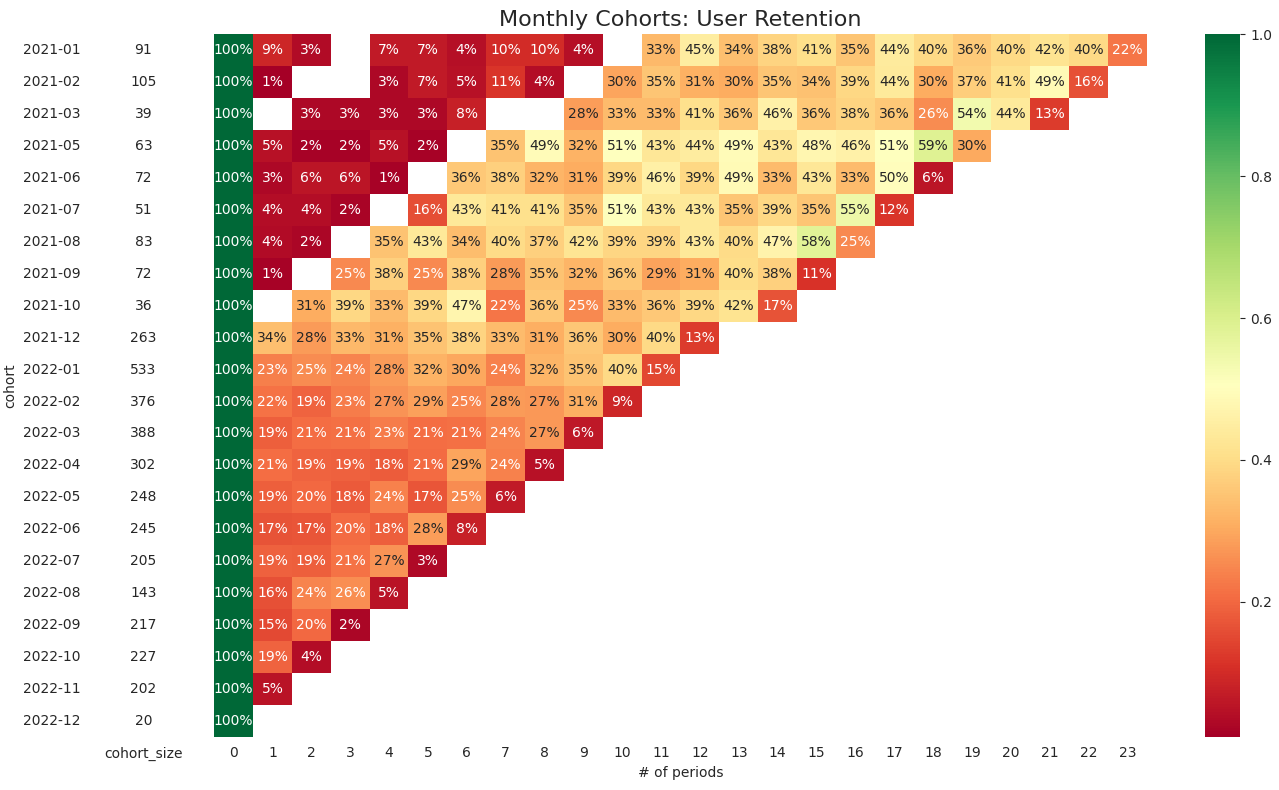

In [55]:
#Create a heatmap of the matrix of the cohorts

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrixa
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

This cohort matrix provides information on user retention for each cohort group over a period of time. The cohorts are organized by the month and year that they first became active, and the period numbers represent the number of months since that initial activation.

The numbers in the matrix represent the proportion of users from each cohort that remained active during each period. A value of 1.0 indicates that all users from the cohort group were active during the initial period, and values less than 1.0 indicate the proportion of users who remained active in subsequent periods.

Overall, the matrix suggests that user retention varies widely across different cohort groups and over time. Some groups show relatively high levels of retention throughout the entire observation period, while others show rapid declines in retention after just a few periods.

For example, the cohort that became active in January 2021 shows relatively high levels of retention over the entire period, with around 40% of users remaining active after 15 periods. However, the cohort that became active in March 2021 shows a rapid decline in retention, with around 46% of users remaining active after just one period, and around 13% remaining active after 15 periods.

The matrix can be used to identify which cohort groups are showing strong retention and which are struggling, and can be used to inform strategies for improving retention rates over time.